<h1 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">Implementing ResNet18 for Image classification - Transfer Learning Approach on Pytorch</h1>

Broadly, the steps done are: 
- Dataset handling by inheriting the Dataset class
- A method called get_model to instantiate the transfer model and change the ending connections to get our desired output (this also includes the loss function and optimizers defined)
- The definitions of the batch_losses and accuracies 
- get_data method to fetch the data, and add it to dataloader to get the batched data in a shuffled manner
- Calculation of losses and accuracies over each epoch and visualizing it

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

print(device)

In [2]:
train_data_dir = '../input/cat-and-dog/training_set/training_set'
test_data_dir = '../input/cat-and-dog/test_set/test_set'

<h2 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">The Dataset</h2>
​
- Following is a class inherited from the Pytorch Dataset class
- It includes adding equal number (500) of data in both the target classes
- get item method returns this index image from the filepath, reads it, crops it to size required by the model, converts it to tensor and permutes it in a way that Pytorch can read it 
- While leveraging pre-trained models, it is mandatory to resize, permute, and then normalize images (as appropriate for that pre- trained model), where the images are first scaled to a value between 0 and 1 across the 3 channels and then normalized to a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225] across the RGB channels.
- The values used for normalizing are the same mean and standard deviation that was used during the training of the pre-trained model.

In [3]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] 
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        print(f)
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [4]:
data = CatsDogs(train_data_dir)

In [5]:
data.__len__()

1000

tensor([0.], device='cuda:0')


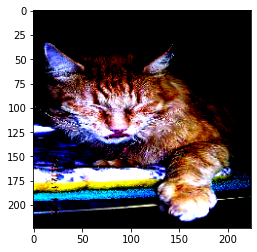

In [6]:
im, label = data[200]
# permute is to just keep it in the matplotlib way to display it
plt.imshow(im.permute(1,2,0).cpu())
print(label)

<h2 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">The get_model</h2>
- This takes in the resnet18, and for every parameters retraining is not allowed, so requires_grad is set to False
- This model is followed by average pool, Flatten, Linear, ReLU, Dropout, Linear and then finally a Sigmoid Layer
- The loss function (is also called criterion) here is Binary Cross entropy as this is dealing with two categorical classfication
- Optimizer used is Adam with a learning rate of $1x10^{-3}$

In [7]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [8]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

<h2 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">The train_batch and accuracy</h2>

- notice model.train() and model.eval() in the classes, which stands for training and evaluation in the train_batch and accuracy methods respectively
- loss_fn is referred to in the get_model() method
- batch_loss is backward propagated, and optimizer finds the gradient step
- zero_grad() flushes out the previous epoch's gradients
- batch_loss is converted to a number from the Pytorch tensor

<br>

- torch.no_grad() is specified to not calculate the gradients for the accuracy method
- is_correct is a parameter calculated when the prediction of a certain class's probability is greater than 0.5, which is fitting since the Sigmoid at the classification end predicts a number between 0 and 1
- Also cpu() is to convert it back to cpu and not utilize a lot of gpu in the process
- Note that the output here in accuracy method is in list form

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [10]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [11]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

<h2 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">The get_data</h2>

- The train goes to the __getitem__ method and fetches all the training data
- It is then converted to DataLoader class to shuffle and fetch a certain batch_size of training data
- Dropping last is to drop last set of batch because it might not confirm to the set batch_size
- Doing the same for validation data too

In [12]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

<h2 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">Calculation of losses and accuracies</h2>

- 5 epochs are perfomed to figure out train_losses, accuracies and validation accuracies through the epochs
- Iterating through train dataloader, picks up the index and the batches
- Since loss metrics were just a number, there was a need to convert them to np.array and then take a mean (Mean as in average of the losses within an epoch)
- Accuracies calculation returned a list, so np.mean is directly used. Also observe the use of append when it is not a list, and extend when it is a list
- Later it is just appended to one huge list, and added to the visualization area (next cell after this)

In [13]:
train_losses, train_accuracies = [], []
val_accuracies = []

print("All losses and accuracies are for each epoch")
for epoch in range(5):
    
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(f" epoch {epoch + 1}/5, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Validation Accuracy: {val_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


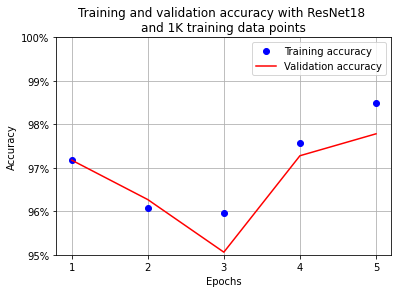

In [14]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()